In [704]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import Data

In [707]:
df = pd.read_csv("combined_df.csv")
df = df[
    (df['Year'] >= 2020) &
    (~(df['Headliner'].str.contains('"', na=False))) & 
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
df = df.dropna()
df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')
# Reset index after dropping rows
df = df.reset_index(drop=True)
df

/var/folders/5p/g82q05js0bs2xkv11dw5ksy80000gn/T/ipykernel_2034/1824778265.py:1: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_df.csv")


,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
0,2024-09-18,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,20295.0,1228939.0,20295.0,100%,39.5,225.0,60.55,9,2
1,2024-09-14,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,16308.0,1374174.0,16308.0,100%,39.5,225.0,84.26,9,5
2,2024-09-13,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,14995.0,1402969.0,14995.0,100%,39.5,225.0,93.56,9,4
3,2024-09-11,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,19303.0,1512310.0,19303.0,100%,39.5,159.5,78.35,9,2
4,2024-09-10,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,10945.0,801952.0,10945.0,100%,39.5,159.5,73.27,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,2020-01-16,Ider,Ider,[],5.0,0.0,Ider,UCv8KgX89OA0yyPVAgoxx5lw,IDER,'Late To The World' OUT NOW! \n\nThe title tra...,...,Pop / Rock,227.0,3282.0,250.0,90%,15.0,100.0,14.46,1,3
3357,2020-01-16,Green Jelly,Green Jelly,"['comic metal', 'funk metal']",60041.0,35.0,Green Jelly,UCW8soHbDw-sZ8X2Cjb-2VcA,Green Jellÿ,Official Channel of Green Jello / Green Jelly\...,...,Pop / Rock,117.0,1260.0,200.0,58%,10.0,12.0,10.77,1,3
3358,2020-01-15,Grace Potter,Grace Potter,[],126207.0,55.0,Grace Potter,UChZPBtiR55itE778bGV3PlQ,Grace Potter,New album “Mother Road” out now: https://found...,...,Pop / Rock,852.0,36679.0,1868.0,45%,38.5,48.5,43.05,1,2
3359,2020-01-15,Caroline Polachek,Caroline Polachek,"['art pop', 'escape room', 'indie pop', 'indie...",542299.0,62.0,Caroline Polachek,UC_YiGpMGuBb1PbjqPQMf9MQ,Caroline Polachek,The official YouTube channel of Caroline Polachek,...,Pop / Rock,500.0,9250.0,500.0,100%,20.0,100.0,18.50,1,2


# Data Preprocessing

In [709]:
# Remove the after-concert data
columns_to_exclude = ['Avg. Tickets Sold', 'Avg. Capacity Sold', 'Ticket Price Avg. USD']
df = df.drop(columns=columns_to_exclude, errors='ignore')

# Extract time features from dates
df['Year'] = df['Event Date'].dt.year
df['Month'] = df['Event Date'].dt.month
df['Day'] = df['Event Date'].dt.day
df['Day_of_Week'] = df['Event Date'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3361 entries, 0 to 3360
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Event Date                       3361 non-null   datetime64[ns]
 1   Headliner                        3361 non-null   object        
 2   sp artist_name                   3361 non-null   object        
 3   sp artist_genre                  3361 non-null   object        
 4   sp followers                     3361 non-null   float64       
 5   sp popularity                    3361 non-null   float64       
 6   yt name                          3361 non-null   object        
 7   yt Channel ID                    3361 non-null   object        
 8   yt Title                         3361 non-null   object        
 9   yt Description                   3361 non-null   object        
 10  yt Published At                  3361 non-null   object     

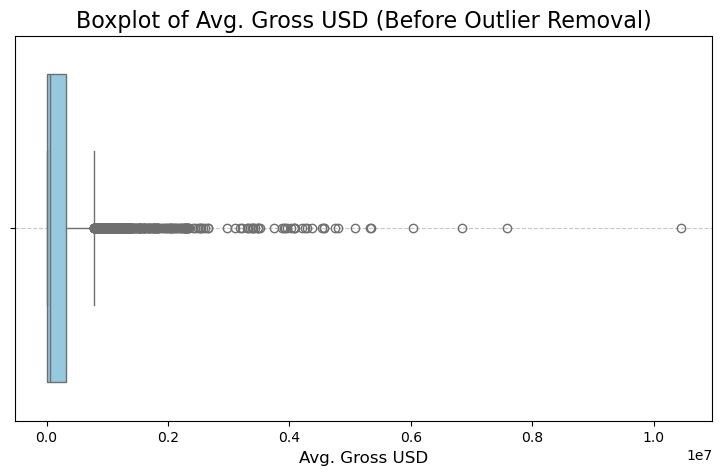

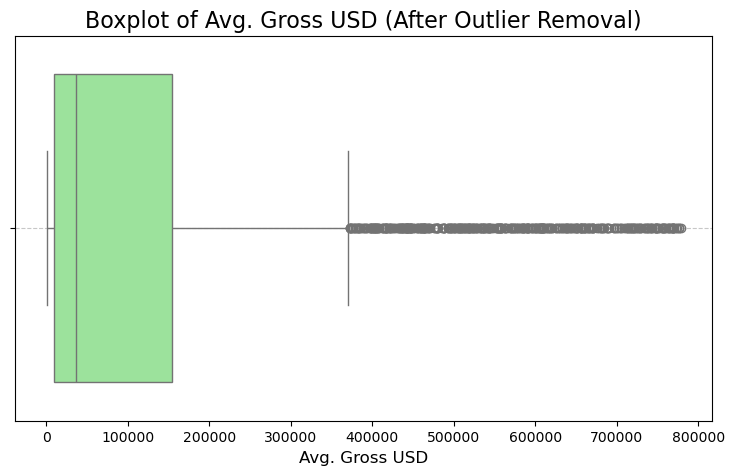

In [710]:
# Boxplot (before excluding outliers)
plt.figure(figsize=(9, 5))
sns.boxplot(x=df['Avg. Gross USD'], color='skyblue')
plt.title("Boxplot of Avg. Gross USD (Before Outlier Removal)", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate the IQR and remove the outliers
q1 = df['Avg. Gross USD'].quantile(0.25)
q3 = df['Avg. Gross USD'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_filtered = df[(df['Avg. Gross USD'] >= lower_bound) & (df['Avg. Gross USD'] <= upper_bound)]

# Boxplot (after excluding outliers)
plt.figure(figsize=(9, 5))
sns.boxplot(x=df_filtered['Avg. Gross USD'], color='lightgreen')
plt.title("Boxplot of Avg. Gross USD (After Outlier Removal)", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Exploratory Data Analysis

In [712]:
# Check statistic analysis for Avg. Gross USD
print("Descriptive Statistics for Avg. Gross USD:")
print(df['Avg. Gross USD'].describe())

# Filters numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation between numerical features and target variables
correlations = df[numeric_columns].corr()['Avg. Gross USD'].sort_values(ascending=False)
print("\nCorrelation of numerical features with Avg. Gross USD:")
print(correlations)

Descriptive Statistics for Avg. Gross USD:
count    3.361000e+03
mean     3.036503e+05
std      6.307795e+05
min      1.900000e+02
25%      1.075500e+04
50%      5.149550e+04
75%      3.179813e+05
max      1.044296e+07
Name: Avg. Gross USD, dtype: float64

Correlation of numerical features with Avg. Gross USD:
Avg. Gross USD                     1.000000
Avg. Event Capacity                0.816177
Ticket Price Max USD               0.584927
sp followers                       0.533951
monthly_listeners                  0.522213
headliner_monthly_listeners        0.522213
sp popularity                      0.456942
yt View Count                      0.427038
Ticket Price Min USD               0.412459
yt Subscriber Count                0.357633
yt Video Count                     0.094437
Number of Shows                    0.068983
10 to 14 years population          0.060112
5 to 9 years population            0.057795
55 to 59 years population          0.056746
15 to 19 years population   

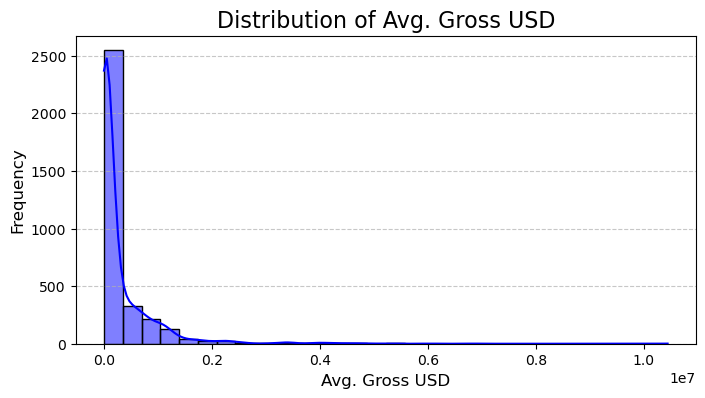

In [713]:
# Target variable distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Avg. Gross USD'], bins=30, kde=True, color='blue')
plt.title("Distribution of Avg. Gross USD", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

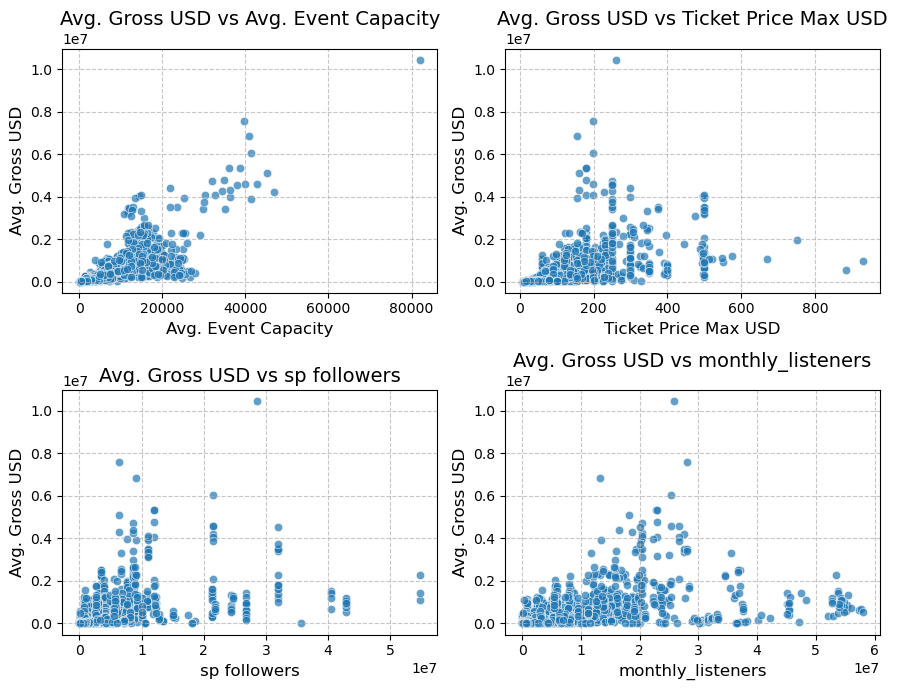

In [714]:
# Top 4 high scores feature related with Avg. Gross USD
features_to_plot = ['Avg. Event Capacity', 'Ticket Price Max USD', 'sp followers', 'monthly_listeners']

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x=df[feature], y=df['Avg. Gross USD'], alpha=0.7, ax=axes[i])
    axes[i].set_title(f"Avg. Gross USD vs {feature}", fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Avg. Gross USD", fontsize=12)
    axes[i].grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [715]:
# Check the types of genres
print("Unique genres in the dataset:")
print(df['Genre'].unique()) # got only one type

print("\nDistribution of genres:")
print(df['Genre'].value_counts())
# Decrease data redundancy and model complexity
df = df.drop(columns=['Genre'], errors='ignore')

Unique genres in the dataset:
['Pop / Rock']

Distribution of genres:
Genre
Pop / Rock    3361
Name: count, dtype: int64


/var/folders/5p/g82q05js0bs2xkv11dw5ksy80000gn/T/ipykernel_2034/3293075121.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['City'].isin(top_cities)], x='City', y='Avg. Gross USD', order=sorted_cities, palette='Set3')


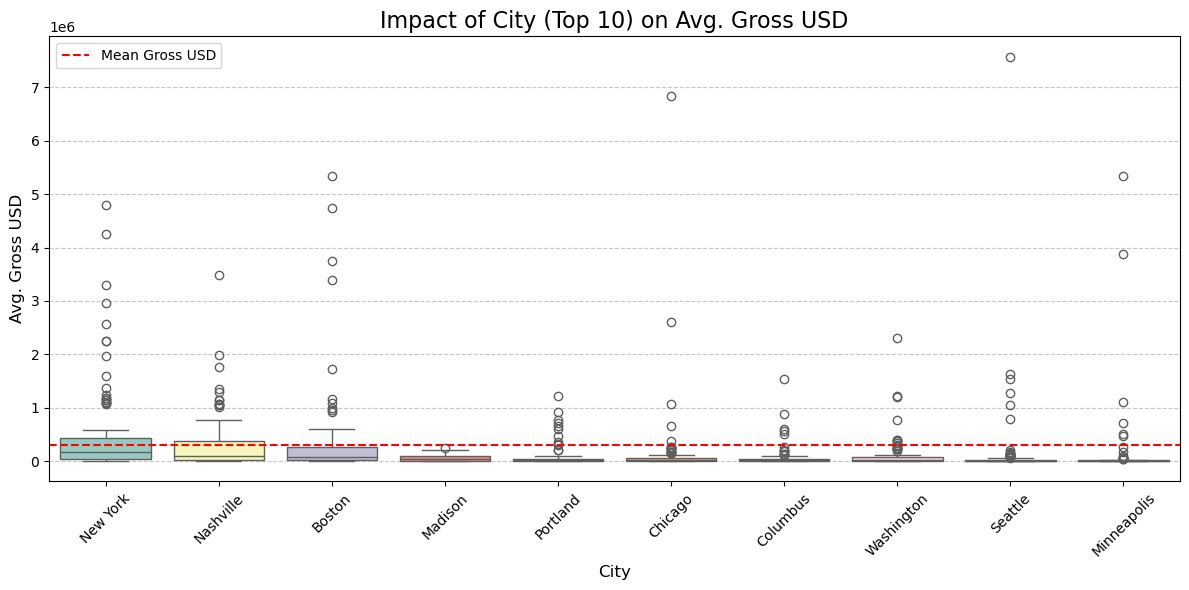

In [716]:
# Impact of City on Avg. Gross USD (Ranked by Median)
top_cities = df['City'].value_counts().head(10).index
median_gross = df[df['City'].isin(top_cities)].groupby('City')['Avg. Gross USD'].median().sort_values(ascending=False)
sorted_cities = median_gross.index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['City'].isin(top_cities)], x='City', y='Avg. Gross USD', order=sorted_cities, palette='Set3')

# Add a reference line
mean_gross = df['Avg. Gross USD'].mean()
plt.axhline(mean_gross, color='red', linestyle='--', linewidth=1.5, label='Mean Gross USD')

plt.title("Impact of City (Top 10) on Avg. Gross USD", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Avg. Gross USD", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Feature Engineering

In [718]:
# Extraction time feature
df['Year'] = df['Event Date'].dt.year
df['Month'] = df['Event Date'].dt.month
df['Day'] = df['Event Date'].dt.day
df['Day_of_Week'] = df['Event Date'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

print(df[['Event Date', 'Year', 'Month', 'Day', 'Day_of_Week', 'Is_Weekend']].head())

  Event Date  Year  Month  Day  Day_of_Week  Is_Weekend
0 2024-09-18  2024      9   18            2           0
1 2024-09-14  2024      9   14            5           1
2 2024-09-13  2024      9   13            4           0
3 2024-09-11  2024      9   11            2           0
4 2024-09-10  2024      9   10            1           0


In [722]:
# Initializes the target encoder
target_encoder = TargetEncoder()

# Target code the City column
df['City_encoded'] = target_encoder.fit_transform(df['City'], df['Avg. Gross USD'])
print(df[['City', 'City_encoded']].head())

            City   City_encoded
0        Raleigh  372286.315796
1  The Woodlands  498265.755355
2    San Antonio  392506.247703
3         Dallas  369553.384283
4         Rogers  359601.979344


In [725]:
# Generated interaction feature
df['Capacity_Ticket_Interaction'] = df['Avg. Event Capacity'] * df['Ticket Price Max USD']

print(df[['Avg. Event Capacity', 'Ticket Price Max USD', 'Capacity_Ticket_Interaction']].head())

   Avg. Event Capacity  Ticket Price Max USD  Capacity_Ticket_Interaction
0              20295.0                 225.0                    4566375.0
1              16308.0                 225.0                    3669300.0
2              14995.0                 225.0                    3373875.0
3              19303.0                 159.5                    3078828.5
4              10945.0                 159.5                    1745727.5


In [726]:
# Calculate city-level statistical features
city_stats = df.groupby('City')['Avg. Gross USD'].agg(['mean', 'median']).reset_index()
city_stats.rename(columns={'mean': 'City_Avg_Gross_Mean', 'median': 'City_Avg_Gross_Median'}, inplace=True)

# Merge statistical features into original data
df = df.merge(city_stats, on='City', how='left')

print(df[['City', 'City_Avg_Gross_Mean', 'City_Avg_Gross_Median']].head())

            City  City_Avg_Gross_Mean  City_Avg_Gross_Median
0        Raleigh        464935.294118             404537.000
1  The Woodlands        890173.226923             948704.000
2    San Antonio        590258.875000              30310.125
3         Dallas        389403.022500              80448.000
4         Rogers        511694.509000             550708.000


In [1047]:
# Filter numrical columns (correlation analysis)
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_with_target = numeric_columns.corr()['Avg. Gross USD'].sort_values(ascending=False)

# Sort correlation
print("\nCorrelation with Avg. Gross USD:")
print(correlation_with_target)

# Filter features by relevance (threshold: 0.1)
selected_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
df_selected = df[selected_features]

print("\nSelected Features:")
print(df_selected.head())


Correlation with Avg. Gross USD:
Avg. Gross USD                     1.000000
Avg. Event Capacity                0.816177
Capacity_Ticket_Interaction        0.771636
Ticket Price Max USD               0.584927
City_Avg_Gross_Mean                0.569458
sp followers                       0.533951
City_Avg_Gross_Median              0.526788
headliner_monthly_listeners        0.522213
monthly_listeners                  0.522213
sp popularity                      0.456942
City_encoded                       0.435316
yt View Count                      0.427038
Ticket Price Min USD               0.412459
yt Subscriber Count                0.357633
yt Video Count                     0.094437
Number of Shows                    0.068983
10 to 14 years population          0.060112
5 to 9 years population            0.057795
55 to 59 years population          0.056746
15 to 19 years population          0.056139
45 to 54 years population          0.055123
Under 5 years population           0.05442

In [1099]:
# Filter features based on correlation (threshold: 0.5)
selected_features = correlation_with_target[correlation_with_target > 0.5].index.tolist()

# Remove non-used feature
selected_features = [feature for feature in selected_features if feature != 'Support_Total_Monthly_Listeners']

# Filtered data set
df_selected = df[selected_features]

print("\nSelected Features for Modeling:")
print(list(df_selected))


Selected Features for Modeling:
['Avg. Gross USD', 'Avg. Event Capacity', 'Capacity_Ticket_Interaction', 'Ticket Price Max USD', 'City_Avg_Gross_Mean', 'sp followers', 'City_Avg_Gross_Median', 'headliner_monthly_listeners', 'monthly_listeners']


# Training Models

### Train test split

In [1103]:
# Define features and target variablex
X = df[['Avg. Event Capacity', 'Capacity_Ticket_Interaction', 'Ticket Price Max USD', 'City_Avg_Gross_Mean', 
        'sp followers', 'City_Avg_Gross_Median', 'monthly_listeners']] # removed 'headliner_monthly_listeners', same as 'monthly_listeners'
y = df['Avg. Gross USD']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (2688, 7), Test set size: (673, 7)


In [1105]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2688, 7)
y_train shape: (2688,)


### Potential Multicollinearity Check (VIF)

In [1108]:
X_for_vif = X_train.copy()
vif_data = pd.DataFrame()
vif_data["Feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

print(vif_data)

                       Feature       VIF
0          Avg. Event Capacity  7.127439
1  Capacity_Ticket_Interaction  7.260654
2         Ticket Price Max USD  4.182821
3          City_Avg_Gross_Mean  9.930895
4                 sp followers  3.904341
5        City_Avg_Gross_Median  8.028150
6            monthly_listeners  4.343182


In [1110]:
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")

Length of X: 3361
Length of y: 3361


#### PCA

In [1113]:
pca_features = X_train[['City_Avg_Gross_Mean', 'City_Avg_Gross_Median']]
X_train_others = X_train.drop(columns=['City_Avg_Gross_Mean', 'City_Avg_Gross_Median'], errors='ignore')

pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_features)

pca_df = pd.DataFrame(principal_components, columns=['PCA1', 'PCA2'])

X_train = pd.concat([X_train_others, pca_df], axis=1)
print(pca.explained_variance_ratio_)

[0.96535283 0.03464717]


In [1115]:
X_train = pd.concat([X_train_others, pca_df[['PCA1']]], axis=1)

X_train.head()

,Avg. Event Capacity,Capacity_Ticket_Interaction,Ticket Price Max USD,sp followers,monthly_listeners,PCA1
1334,16830.0,2103750.0,125.0,4471243.0,10368486.0,-261699.339655
676,1000.0,30000.0,30.0,52224.0,164523.0,-196473.537808
1399,683.0,64885.0,95.0,355098.0,692755.0,-224816.451228
839,1088.0,23936.0,22.0,235674.0,962418.0,-188728.959632
999,18989.0,2563515.0,135.0,4181915.0,6059442.0,-170484.123836


In [1117]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (3227, 6)
y_train shape: (2688,)


In [1119]:
print(X_train.isnull().sum())
print(np.isinf(X_train).sum())

Avg. Event Capacity            539
Capacity_Ticket_Interaction    539
Ticket Price Max USD           539
sp followers                   539
monthly_listeners              539
PCA1                           539
dtype: int64
Avg. Event Capacity            0
Capacity_Ticket_Interaction    0
Ticket Price Max USD           0
sp followers                   0
monthly_listeners              0
PCA1                           0
dtype: int64


In [1141]:
print(f"X_train shape before fillna: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Fill empty values with the mean
train_means = X_train.mean()
X_train_filled = X_train.fillna(train_means)

print("Missing values in X_train after filling:", X_train_filled.isnull().sum().sum())

# Make sure X_train and y_train are aligned
common_indices = X_train_filled.index.intersection(y_train.index)
X_train_align = X_train_filled.loc[common_indices]
y_train_align = y_train.loc[common_indices]

print(f"X_train shape after alignment: {X_train_align.shape}")
print(f"y_train shape after alignment: {y_train_align.shape}")

X_train shape before fillna: (3227, 6)
y_train shape: (2688,)
Missing values in X_train after filling: 0
X_train shape after alignment: (2688, 6)
y_train shape after alignment: (2688,)


In [1143]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_align.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_align.values, i) for i in range(X_train_align.shape[1])]

print(vif_data) # PCA1 Replace the original 'City_Avg_Gross_Mean' and 'City_Avg_Gross_Median' features

                       Feature       VIF
0          Avg. Event Capacity  5.881228
1  Capacity_Ticket_Interaction  6.634872
2         Ticket Price Max USD  3.521953
3                 sp followers  3.893294
4            monthly_listeners  4.310061
5                         PCA1  1.001312


In [1147]:
# Perform PCA transformation on the test set
pca_features_test = X_test[['City_Avg_Gross_Mean', 'City_Avg_Gross_Median']]
X_test_others = X_test.drop(columns=['City_Avg_Gross_Mean', 'City_Avg_Gross_Median'], errors='ignore')

principal_components_test = pca.transform(pca_features_test)
pca_df_test = pd.DataFrame(principal_components_test, columns=['PCA1', 'PCA2'])

X_test = pd.concat([X_test_others, pca_df_test[['PCA1']]], axis=1)

In [1165]:
print(f"X_train shape: {X_test.shape}")
print(f"y_train shape: {y_test.shape}")

X_train shape: (1189, 6)
y_train shape: (673,)


In [1169]:
# Fill empty values with the mean
test_means = X_test.mean()
X_test_filled = X_test.fillna(test_means)

# Make sure X_test and y_test are aligned
common_indices_test = X_test_filled.index.intersection(y_test.index)
X_test_align = X_test_filled.loc[common_indices_test]
y_test_align = y_test.loc[common_indices_test]

print(f"X_test shape after alignment: {X_test_align.shape}")
print(f"y_test shape after alignment: {y_test_align.shape}")

X_test shape after alignment: (673, 6)
y_test shape after alignment: (673,)


## Linear Regression

In [1277]:
# Linear Regression (3 types)
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=1.0, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
}
results = {}
print("### Cross-Validation ###")
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    mae_scores = cross_val_score(pipeline, X_train_aligned, y_train_aligned, cv=5, scoring='neg_mean_absolute_error')
    mse_scores = cross_val_score(pipeline, X_train_aligned, y_train_aligned, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(pipeline, X_train_aligned, y_train_aligned, cv=5, scoring='r2')

    avg_mae = -np.mean(mae_scores)
    avg_rmse = np.sqrt(-np.mean(mse_scores))
    avg_r2 = np.mean(r2_scores)

    print(f"  Cross-Validation Average MAE: {avg_mae:.2f}")
    print(f"  Cross-Validation Average RMSE: {avg_rmse:.2f}")
    print(f"  Cross-Validation Average R²: {avg_r2:.2f}")
    print("-" * 30)
    results[model_name] = {
        "CV_MAE": avg_mae,
        "CV_RMSE": avg_rmse,
        "CV_R²": avg_r2,
    }

print("\n### Test Set Evaluation ###")
for model_name, model in models.items():
    print(f"Evaluating {model_name} on Test Set...")
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])
    pipeline.fit(X_train_aligned, y_train_aligned)
    y_test_pred = pipeline.predict(X_test_aligned)

    test_mae = mean_absolute_error(y_test_aligned, y_test_pred)
    test_rmse = mean_squared_error(y_test_aligned, y_test_pred, squared=False)
    test_r2 = r2_score(y_test_aligned, y_test_pred)

    print(f"  Test Set MAE: {test_mae:.2f}")
    print(f"  Test Set RMSE: {test_rmse:.2f}")
    print(f"  Test Set R²: {test_r2:.2f}")
    print("-" * 30)

### Cross-Validation ###
Evaluating Linear Regression...
  Cross-Validation Average MAE: 137716.90
  Cross-Validation Average RMSE: 345496.63
  Cross-Validation Average R²: 0.70
------------------------------
Evaluating Lasso Regression...
  Cross-Validation Average MAE: 137716.75
  Cross-Validation Average RMSE: 345496.64
  Cross-Validation Average R²: 0.70
------------------------------
Evaluating Ridge Regression...
  Cross-Validation Average MAE: 137697.08
  Cross-Validation Average RMSE: 345489.71
  Cross-Validation Average R²: 0.70
------------------------------

### Test Set Evaluation ###
Evaluating Linear Regression on Test Set...
  Test Set MAE: 153996.14
  Test Set RMSE: 368278.95
  Test Set R²: 0.62
------------------------------
Evaluating Lasso Regression on Test Set...
  Test Set MAE: 153996.05
  Test Set RMSE: 368278.35
  Test Set R²: 0.62
------------------------------
Evaluating Ridge Regression on Test Set...
  Test Set MAE: 153975.78
  Test Set RMSE: 368233.96
  Tes

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Random Forest

In [1194]:
# Random Forest (without tune hyperparameter)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# CV MAE
mae_scores = -cross_val_score(rf_model, X, y, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(rf_model, X, y, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(rf_model, X, y, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("Random Forest Cross-Validation Results:")
print(f"  Average MAE: {avg_mae:.5f}")
print(f"  Average RMSE: {avg_rmse:.5f}")
print(f"  Average R^2: {avg_r2:.5f}")

Random Forest Cross-Validation Results:
  Average MAE: 105457.33386
  Average RMSE: 286769.56281
  Average R^2: 0.73157


In [1195]:
# Random Forest (tune hyperparameter)
param_distributions = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)

# Random Search (In a large space)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_align, y_train_align)

print("Random Search Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Random Search Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None}


In [1196]:
# Use GridSearchCV for a more refined search
param_grid = {
    'n_estimators': [450, 500, 550],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt']
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_align, y_train_align)

print("Grid Search Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Grid Search Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 550}


In [1197]:
# Initialize the final model with the best parameters
final_rf_model = RandomForestRegressor(
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=500,
    random_state=42
)

final_rf_model.fit(X_train_align, y_train_align)

RandomForestRegressor(max_features=None, min_samples_split=3, n_estimators=500,
                      random_state=42)

In [1199]:
# Evaluates model performance using cross-validation on the training set
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# CV MAE
mae_scores = -cross_val_score(final_rf_model, X_train_align, y_train, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(final_rf_model, X_train_align, y_train, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(final_rf_model, X_train_align, y_train, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("Cross-Validation Results (Training Set):")
print(f"  Average MAE: {avg_mae:.5f}")
print(f"  Average RMSE: {avg_rmse:.5f}")
print(f"  Average R^2: {avg_r2:.5f}")

Cross-Validation Results (Training Set):
  Average MAE: 76317.88668
  Average RMSE: 218774.30658
  Average R^2: 0.87819


In [1261]:
# Evaluates final performance on test set

y_test_pred_rf = final_rf_model.predict(X_test_align)

test_mae = mean_absolute_error(y_test_align, y_test_pred_rf)
test_rmse = np.sqrt(mean_squared_error(y_test_align, y_test_pred_rf))
test_r2 = r2_score(y_test_align, y_test_pred_rf)

print("Test Set Results:")
print(f"  MAE: {test_mae:.5f}")
print(f"  RMSE: {test_rmse:.5f}")
print(f"  R^2: {test_r2:.5f}")

Test Set Results:
  MAE: 74582.37125
  RMSE: 191546.29232
  R^2: 0.89777


In [1201]:
# Find feature importance of final_rf model

feature_importances = final_rf_model.feature_importances_
for name, importance in zip(X_train.columns, feature_importances):
    print(f"{name}: {importance:.4f}")

Avg. Event Capacity: 0.3876
Capacity_Ticket_Interaction: 0.4651
Ticket Price Max USD: 0.0388
sp followers: 0.0547
monthly_listeners: 0.0441
PCA1: 0.0097


## XGBoost

In [1202]:
# XGBoost (without tune hyperparameter)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# CV MAE
mae_scores = -cross_val_score(xgb_model, X, y, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(xgb_model, X, y, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("XGBoost Cross-Validation Results:")
print(f"  Average MAE: {avg_mae:.2f}")
print(f"  Average RMSE: {avg_rmse:.2f}")
print(f"  Average R^2: {avg_r2:.2f}")

XGBoost Cross-Validation Results:
  Average MAE: 99391.23
  Average RMSE: 265969.34
  Average R^2: 0.78


In [1203]:
# XGBoost (tune hyperparameter)

param_distributions = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 15],
    'min_child_weight': [1, 2, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Random Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_align, y_train_align)

print("Random Search Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Search Best Parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [1204]:
# Use GridSearchCV for a more refined search
param_grid = {
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [4, 5, 6], 
    'n_estimators': [450, 500, 550],
    'subsample': [0.6],
    'colsample_bytree': [1.0],
    'min_child_weight': [1],
    'gamma': [0.4, 0.5, 0.6],
    'reg_alpha': [0.5, 1, 1.5],
    'reg_lambda': [2.5, 3, 3.5]
}

#  Grid Search CV
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    # verbose=2,
    verbose=0,  # Set verbose to 0 to suppress detailed output
    n_jobs=-1
)

grid_search.fit(X_train_align, y_train_align)

print("Grid Search Best Parameters:", grid_search.best_params_)

Grid Search Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.4, 'learning_rate': 0.08, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 450, 'reg_alpha': 1, 'reg_lambda': 2.5, 'subsample': 0.6}


In [1205]:
# Initialize the XGBoost model with the best parameters
final_xgb_model = XGBRegressor(
    colsample_bytree=1.0,
    gamma=0.4,
    learning_rate=0.12,
    max_depth=4,
    min_child_weight=1,
    n_estimators=550,
    reg_alpha=0.5,
    reg_lambda=2.5,
    subsample=0.6,
    random_state=42,
    objective='reg:squarederror'
)

final_xgb_model.fit(X_train_align, y_train_align)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [1237]:
# Evaluates model performance using cross-validation on the training set
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# CV MAE
mae_scores = -cross_val_score(final_xgb_model, X_train_align, y_train_align, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(final_xgb_model, X_train_align, y_train_align, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(final_xgb_model, X_train_align, y_train_align, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("Cross-Validation Results (Training Set):")
print(f"  Average MAE: {avg_mae:.5f}")
print(f"  Average RMSE: {avg_rmse:.5f}")
print(f"  Average R^2: {avg_r2:.5f}")

Cross-Validation Results (Training Set):
  Average MAE: 76448.15571
  Average RMSE: 217328.25974
  Average R^2: 0.88186


In [1241]:
# Evaluates final performance on test set
y_test_pred_xgb = final_xgb_model.predict(X_test_align)

test_mae = mean_absolute_error(y_test_align, y_test_pred_xgb)
test_rmse = np.sqrt(mean_squared_error(y_test_align, y_test_pred_xgb))
test_r2 = r2_score(y_test_align, y_test_pred_xgb)

print("Test Set Results:")
print(f"  MAE: {test_mae:.5f}")
print(f"  RMSE: {test_rmse:.5f}")
print(f"  R^2: {test_r2:.5f}")

Test Set Results:
  MAE: 73905.12481
  RMSE: 189730.94905
  R^2: 0.89970


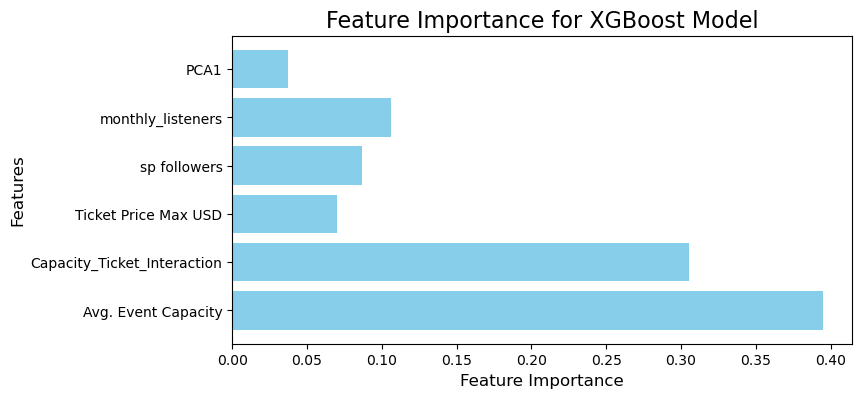

In [1209]:
feature_importances = final_xgb_model.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(X_train_align.columns, feature_importances, color='skyblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance for XGBoost Model', fontsize=16)
plt.show()

## Ensemble models

### Weighted average

In [1212]:
rf_test_pred = final_rf_model.predict(X_test_align)
xgb_test_pred = final_xgb_model.predict(X_test_align)

# define weight
weight_rf = 0.5
weight_xgb = 0.5

# weighted average
ensemble_test_pred = (weight_rf * rf_test_pred) + (weight_xgb * xgb_test_pred)

test_mae = mean_absolute_error(y_test_align, ensemble_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_align, ensemble_test_pred))
test_r2 = r2_score(y_test_align, ensemble_test_pred)

print("Ensemble Model (Weighted Average) Test Results:")
print(f"  MAE: {test_mae:.5f}")
print(f"  RMSE: {test_rmse:.5f}")
print(f"  R²: {test_r2:.5f}")

Ensemble Model (Weighted Average) Test Results:
  MAE: 68285.92080
  RMSE: 184320.35496
  R²: 0.90534


### Stacking

In [1214]:
# meta_model = LinearRegression()
# meta_model = Lasso(alpha=0.1)
meta_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_oof = np.zeros(len(X_train_align))
xgb_oof = np.zeros(len(X_train_align))
meta_features = np.zeros((len(X_test_align), 2))

In [1231]:
# Generate OOF predictions
for train_idx, val_idx in kf.split(X_train_align):
    
    X_train_fold, X_val_fold = X_train_align.iloc[train_idx], X_train_align.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_align.iloc[train_idx], y_train_align.iloc[val_idx]

    final_rf_model.fit(X_train_fold, y_train_fold)
    rf_oof[val_idx] = final_rf_model.predict(X_val_fold)

    final_xgb_model.fit(X_train_fold, y_train_fold)
    xgb_oof[val_idx] = final_xgb_model.predict(X_val_fold)

meta_features[:, 0] = final_rf_model.predict(X_test_align)
meta_features[:, 1] = final_xgb_model.predict(X_test_align)

# train by metamodel
stacked_train = np.vstack((rf_oof, xgb_oof)).T
meta_model.fit(stacked_train, y_train_align)

# predict by metamodel
stacked_test = meta_features
stacked_test_pred = meta_model.predict(stacked_test)

test_mae = mean_absolute_error(y_test_align, stacked_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_align, stacked_test_pred))
test_r2 = r2_score(y_test_align, stacked_test_pred)

print("Stacking Ensemble Test Results:")
print(f"  MAE: {test_mae:.5f}")
print(f"  RMSE: {test_rmse:.5f}")
print(f"  R²: {test_r2:.5f}")

Stacking Ensemble Test Results:
  MAE: 71612.12139
  RMSE: 185273.00090
  R²: 0.90436


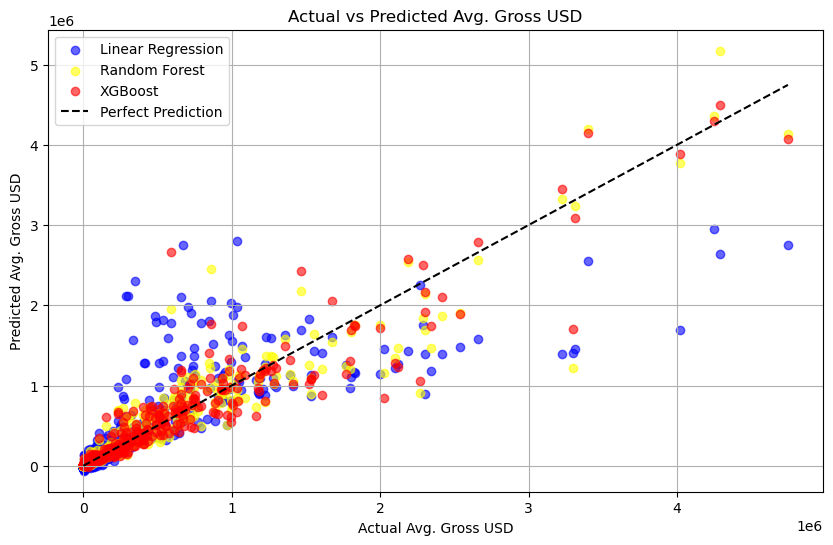

In [1279]:
# actual value against the predicted value
plt.figure(figsize=(10, 6))
plt.scatter(y_test_align, y_test_pred, alpha=0.6, label='Linear Regression', color='blue')
plt.scatter(y_test_align, y_test_pred_rf, alpha=0.6, label='Random Forest', color='yellow')
plt.scatter(y_test_align, y_test_pred_xgb, alpha=0.6, label='XGBoost', color='red')
plt.plot([y_test_align.min(), y_test_align.max()], [y_test_align.min(), y_test_align.max()], '--', color='black', label='Perfect Prediction')
plt.xlabel('Actual Avg. Gross USD')
plt.ylabel('Predicted Avg. Gross USD')
plt.title('Actual vs Predicted Avg. Gross USD')
plt.legend()
plt.grid()
plt.show()